In [1]:
## Update the daasets library to latest version to download the data directly from hugging face
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [30]:
## Imports
import pandas as pd
import numpy as np

from datasets import load_dataset
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load the Full Dataset from Hugging Face
full_dataset = load_dataset("ucberkeley-dlab/measuring-hate-speech")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

measuring-hate-speech.parquet:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/135556 [00:00<?, ? examples/s]

In [29]:
full_dataset

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [32]:
## Sample Dataset with 10% of the records
sampled_dataset = full_dataset['train'].train_test_split(train_size=0.1, seed=42)['train']
train_test_split = sampled_dataset.train_test_split(train_size=0.8, seed=42)

train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

print(f"Full dataset size: {len(full_dataset['train'])}")
print(f"Sampled dataset size: {len(sampled_dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Full dataset size: 135556
Sampled dataset size: 13555
Train dataset size: 10844
Test dataset size: 2711


In [33]:
# Convert the dataset to a pandas DataFrame for easier EDA
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

In [34]:
#Check Top 5 Train Rows
train_df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,49982,3578,3,2.0,2.0,2.0,2.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
1,20014,4762,1,3.0,2.0,3.0,3.0,3.0,4.0,1.0,...,False,False,False,False,False,False,False,False,True,False
2,18699,6703,0,3.0,4.0,3.0,3.0,3.0,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
3,7695,4480,0,4.0,4.0,3.0,2.0,3.0,3.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,30911,2071,2,4.0,3.0,3.0,3.0,2.0,3.0,1.0,...,False,False,False,False,False,False,True,False,False,False


In [35]:
#Check Top 5 Test Rows
test_df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,20060,2588,1,1.0,2.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,20027,8644,1,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,9772,4021,0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,24391,10186,2,4.0,4.0,4.0,4.0,4.0,4.0,1.0,...,False,False,True,False,False,False,False,False,True,False
4,19199,5922,0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [8]:
target_labels = [
    'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize',
    'violence', 'genocide', 'attack_defend', 'hatespeech'
]

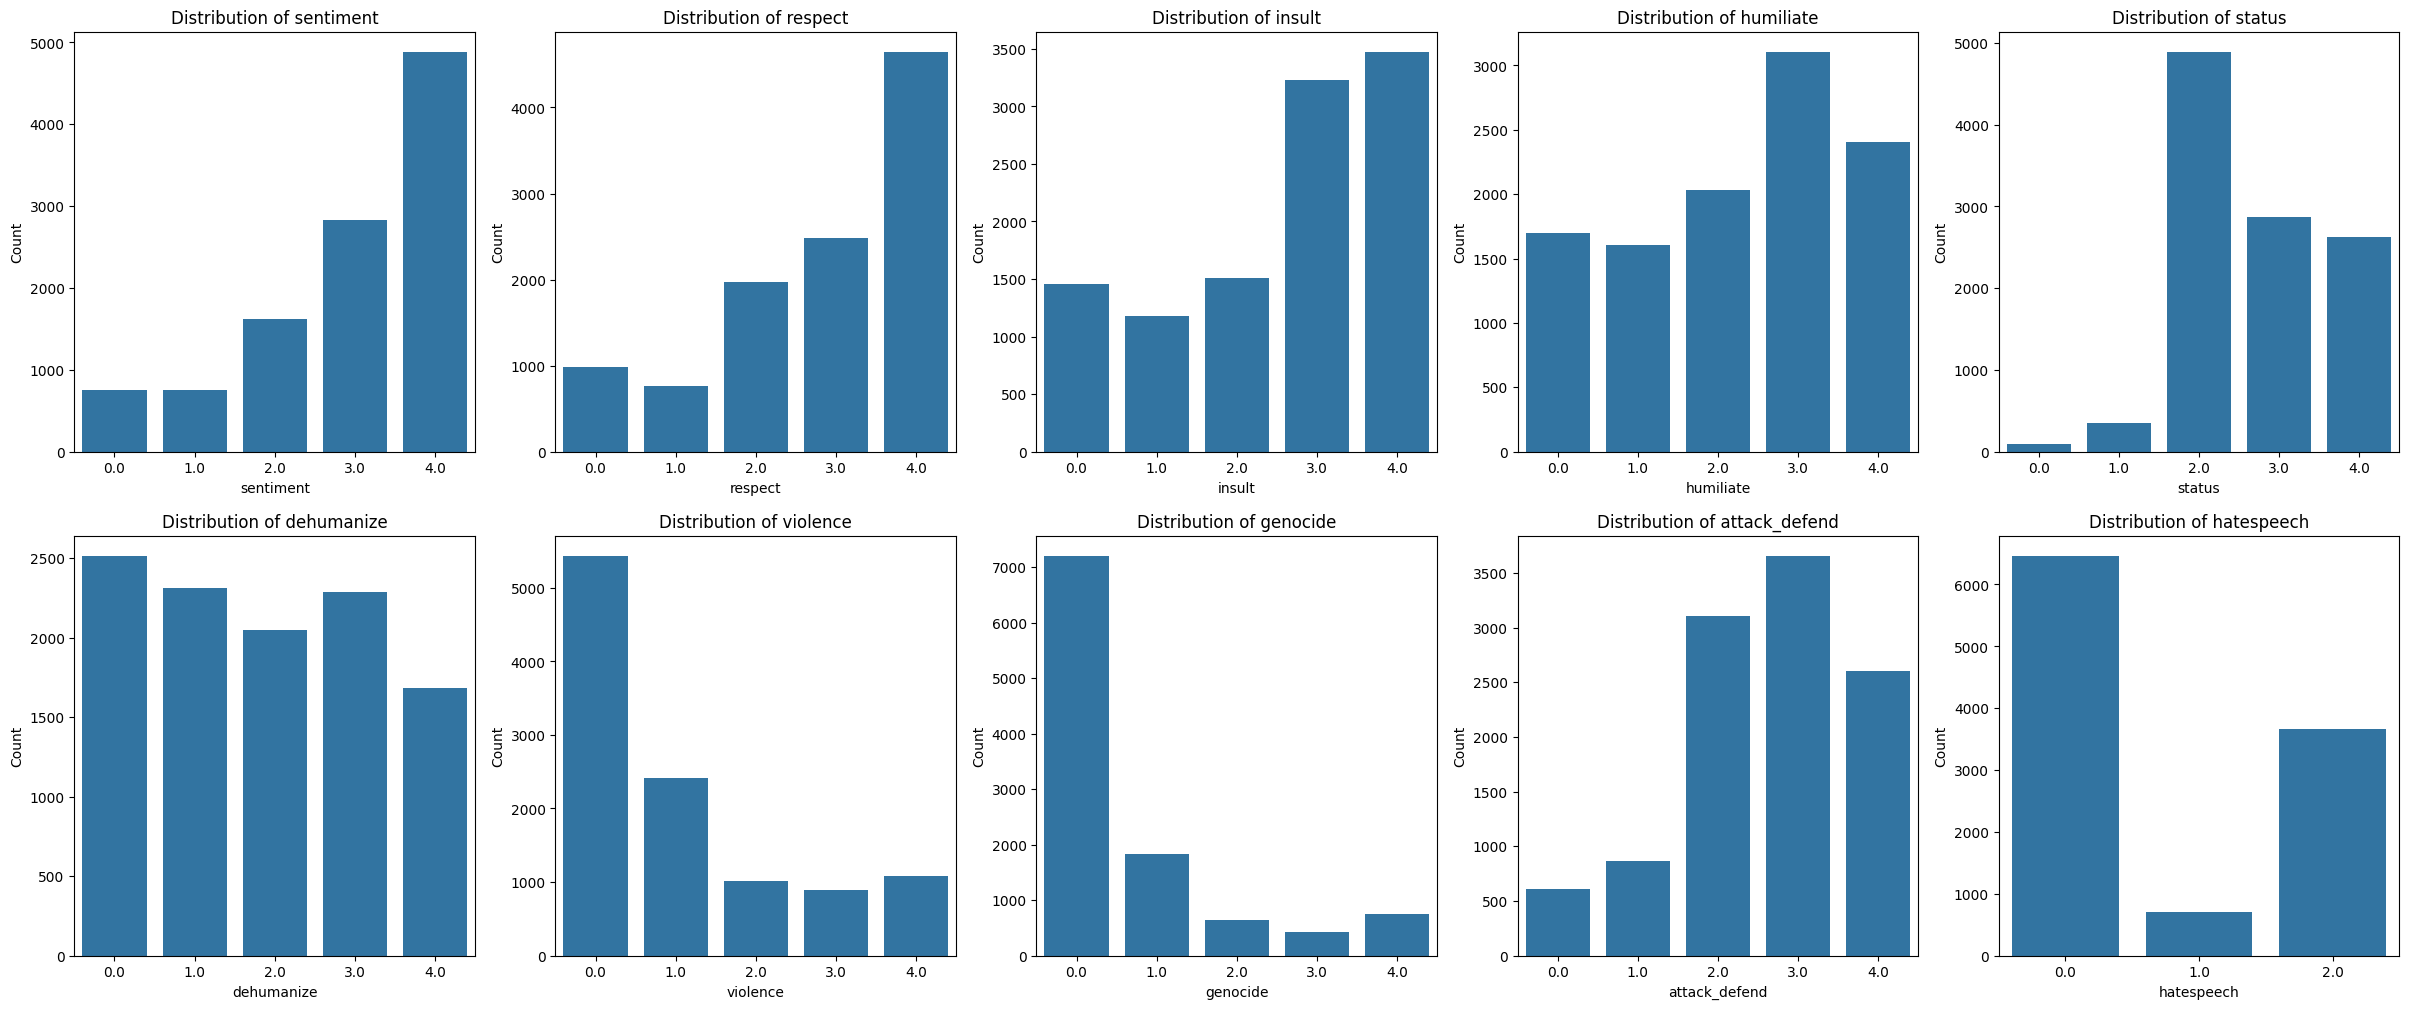

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))  # Adjust size as needed
axes = axes.flatten()

for i, label in enumerate(target_labels):
    sns.countplot(x=label, data=train_df, ax=axes[i])
    axes[i].set_title(f'Distribution of {label}')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Count')

In [41]:
def preprocess_function(examples):
    # Tokenize the text
    tokenized_batch = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

    # Create a 'labels' tensor from the 10 target columns
    labels = [examples[label] for label in target_labels]

    # Transpose the list of lists to group each example's labels together
    # zip(*labels) turns: [[l1_1, l1_2], [l2_1, l2_2]] → [(l1_1, l2_1), (l1_2, l2_2)]
    # Then convert each tuple to list and wrap all of them into a FloatTensor
    tokenized_batch['labels'] = torch.tensor([list(row) for row in zip(*labels)], dtype=torch.float)

    return tokenized_batch


print("Preprocessing data...")
# Initialize the tokenizer using the 'roberta-base' pre-trained model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Apply the preprocess_function to the train and test splits of the dataset
# batched=True processes the data in batches for efficiency
# remove_columns removes the original columns to keep only the tokenized data and labels
processed_dataset = train_test_split.map(preprocess_function, batched=True, remove_columns=train_test_split['train'].column_names)

# Assign the processed train and test splits to new variables
train_dataset = processed_dataset['train']
eval_dataset = processed_dataset['test']

Preprocessing data...


Map:   0%|          | 0/10844 [00:00<?, ? examples/s]

Map:   0%|          | 0/2711 [00:00<?, ? examples/s]

In [10]:
# Load the Model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(target_labels),

    """ We're setting problem_type to "multi_label_classification" to ensure the model outputs
    multiple independent values (one per label) using a sigmoid activation.
    Since Hugging Face doesn't natively support "multi_output_regression" in this class,
    so we'll use this mode and later override the loss function to use MSELoss instead of Classification Loss."""

    problem_type="multi_label_classification"
)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
## Custom Trainer for Multi-output Regression using MSE Loss
from transformers import Trainer
import torch

class RegressionTrainer(Trainer):
    # Override the compute_loss method to use MSELoss instead of default classification loss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract the 'labels' tensor from inputs dictionary and remove it from inputs
        labels = inputs.pop("labels")

        # Forward pass: compute model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: (batch_size, num_labels)

        # Define Mean Squared Error loss (suitable for regression tasks)
        loss_fct = torch.nn.MSELoss()

        # Compute loss between predicted logits and true labels
        loss = loss_fct(logits, labels.float())  # Ensure labels are float type for regression

        # Return the loss and outputs if return_outputs=True (needed for eval/prediction)
        return (loss, outputs) if return_outputs else loss


In [43]:
def compute_metrics(p: EvalPrediction):
    # Extract the predictions; handle case where predictions come as a tuple (e.g., with loss)
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

    # Compute Mean Squared Error (MSE) for each target label
    # multioutput='raw_values' returns a separate error value for each output dimension
    mse = mean_squared_error(p.label_ids, preds, multioutput='raw_values')

    # Compute Mean Absolute Error (MAE) for each target label
    mae = mean_absolute_error(p.label_ids, preds, multioutput='raw_values')

    # Create a dictionary mapping label names to their MSE scores
    metrics = {f'mse_{label}': value for label, value in zip(target_labels, mse)}

    # Add MAE scores to the dictionary using the same label names
    metrics.update({f'mae_{label}': value for label, value in zip(target_labels, mae)})

    # Return a combined dictionary of metrics (MSE + MAE per label)
    return metrics

In [44]:
# ====== CONFIGURABLE PARAMETERS ======
OUTPUT_DIR = './results_test_run'              # Directory to save model checkpoints and results
LOGGING_DIR = './logs_test'                    # Directory for logging
MAX_STEPS = 1000                               # Total number of training steps (overrides epochs)
EVAL_STEPS = 100                               # Run evaluation every 100 steps
SAVE_STEPS = 100                               # Save model every 100 steps
WARMUP_STEPS = 100                             # Steps for learning rate warm-up
WEIGHT_DECAY = 0.01                            # Weight decay for regularization
PER_DEVICE_TRAIN_BATCH_SIZE = 128              # Batch size for training on each device (GPU/CPU)
PER_DEVICE_EVAL_BATCH_SIZE = 128               # Batch size for evaluation
USE_FP16 = True                                # Enable 16-bit precision training (requires compatible GPU)
LOAD_BEST_MODEL_AT_END = True                  # Load the best checkpoint (based on eval loss) at the end
REPORT_TO = "none"                             # Disable external logging (e.g., WandB)
EVAL_STRATEGY = "steps"                        # Evaluation interval strategy
SAVE_STRATEGY = "steps"                        # Saving interval strategy

# ====== TRAINING ARGUMENTS ======
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    logging_dir=LOGGING_DIR,
    eval_strategy=EVAL_STRATEGY,
    eval_steps=EVAL_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    report_to=REPORT_TO,
    fp16=USE_FP16,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END
)

In [25]:
trainer = RegressionTrainer(
    model=model,                        # Model to be trained
    args=training_args,                 # Training configuration
    train_dataset=train_dataset,        # Training data
    eval_dataset=eval_dataset,          # Evaluation data
    compute_metrics=compute_metrics,    # Custom evaluation metrics
    tokenizer=tokenizer,                # Tokenizer for preprocessing
)

/tmp/ipython-input-25-4168137593.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `RegressionTrainer.__init__`. Use `processing_class` instead.
  trainer = RegressionTrainer(


In [26]:
print("Starting training...")
trainer.train()

Starting training...


Step,Training Loss,Validation Loss,Mse Sentiment,Mse Respect,Mse Insult,Mse Humiliate,Mse Status,Mse Dehumanize,Mse Violence,Mse Genocide,Mse Attack Defend,Mse Hatespeech,Mae Sentiment,Mae Respect,Mae Insult,Mae Humiliate,Mae Status,Mae Dehumanize,Mae Violence,Mae Genocide,Mae Attack Defend,Mae Hatespeech
100,No log,0.752562,0.570762,0.626669,0.826340,0.932607,0.573360,1.262787,0.885325,0.685294,0.698627,0.463868,0.551414,0.574729,0.696620,0.773952,0.589606,0.924327,0.701085,0.559138,0.660449,0.485992
200,No log,0.755655,0.599394,0.636039,0.849636,0.925869,0.591958,1.257639,0.862925,0.681814,0.686562,0.464731,0.550030,0.564635,0.671425,0.768860,0.572147,0.909474,0.709177,0.584433,0.650363,0.505551
300,No log,0.763887,0.620876,0.665408,0.875465,0.959842,0.569119,1.281194,0.850317,0.651097,0.716068,0.449498,0.558948,0.569330,0.677930,0.761304,0.577584,0.898852,0.676832,0.556933,0.640534,0.448070
400,No log,0.774655,0.635519,0.693546,0.893154,0.970187,0.570816,1.285154,0.860146,0.660971,0.706379,0.470693,0.551176,0.573458,0.686221,0.771377,0.574196,0.906709,0.668889,0.512078,0.646804,0.452709
500,0.663900,0.782252,0.621343,0.672300,0.898940,0.997540,0.578818,1.356321,0.873035,0.649261,0.716889,0.458090,0.545163,0.567666,0.689859,0.776914,0.572409,0.917089,0.652806,0.495656,0.643188,0.442696
600,0.663900,0.786068,0.638621,0.697606,0.924456,1.027136,0.574488,1.339242,0.846473,0.657892,0.708175,0.446613,0.559171,0.582751,0.699576,0.780805,0.568949,0.916524,0.642837,0.496360,0.639834,0.436705
700,0.663900,0.781223,0.635216,0.689437,0.906935,1.006606,0.567540,1.362810,0.845309,0.645124,0.704686,0.448580,0.554059,0.575431,0.693443,0.777191,0.567554,0.923524,0.655492,0.517398,0.633052,0.435024
800,0.663900,0.794318,0.624005,0.685224,0.924209,1.046774,0.595023,1.393432,0.861507,0.634815,0.712801,0.465402,0.553384,0.574526,0.689779,0.784497,0.574165,0.930367,0.652715,0.520447,0.626794,0.457346
900,0.663900,0.791319,0.631519,0.689981,0.928801,1.032778,0.578781,1.380488,0.861354,0.634734,0.723806,0.450953,0.555334,0.577908,0.686833,0.783131,0.564140,0.933632,0.665138,0.532351,0.628053,0.433174
1000,0.470600,0.788180,0.616831,0.680591,0.911768,1.025241,0.574883,1.393261,0.869967,0.647065,0.709232,0.452976,0.546850,0.574281,0.686753,0.782496,0.562859,0.934224,0.659083,0.522815,0.625153,0.438637


TrainOutput(global_step=1000, training_loss=0.5672781219482422, metrics={'train_runtime': 703.208, 'train_samples_per_second': 182.023, 'train_steps_per_second': 1.422, 'total_flos': 8394108672251904.0, 'train_loss': 0.5672781219482422, 'epoch': 11.764705882352942})

In [ ]:
# Perform predictions on the test dataset
predictions = trainer.predict(eval_dataset)

# Extract predictions (logits) and actual labels
predicted_logits = predictions.predictions
actual_labels = predictions.label_ids
predicted_values = predicted_logits  # In regression, logits are the predictions

In [54]:
# Prepare rows for the DataFrame
rows = []
num_examples_to_show = 20

for i in range(min(num_examples_to_show, len(eval_dataset))):
    row = {"Text": test_dataset[i]['text']}
    for j, label in enumerate(target_labels):
        row[f"Actual_{label}"] = actual_labels[i][j]
        row[f"Predicted_{label}"] = predicted_values[i][j]
    rows.append(row)

# Create DataFrame
df_results = pd.DataFrame(rows)

# Display the table
pd.set_option('display.max_colwidth', None)  # To show full text
pd.set_option('display.max_columns', None) # To show all columns
df_results

,Text,Actual_sentiment,Predicted_sentiment,Actual_respect,Predicted_respect,Actual_insult,Predicted_insult,Actual_humiliate,Predicted_humiliate,Actual_status,Predicted_status,Actual_dehumanize,Predicted_dehumanize,Actual_violence,Predicted_violence,Actual_genocide,Predicted_genocide,Actual_attack_defend,Predicted_attack_defend,Actual_hatespeech,Predicted_hatespeech
0,I love that you enjoy being trans.,1.0,0.545410,2.0,0.692383,0.0,0.610840,0.0,0.556641,2.0,1.992188,0.0,0.627441,0.0,0.307129,0.0,0.230713,2.0,1.327148,0.0,0.031860
1,do you have autism or something? why do you talk like a disgusting retard?,4.0,4.085938,4.0,4.074219,4.0,3.859375,4.0,3.626953,4.0,3.671875,4.0,2.814453,0.0,0.638184,0.0,0.237793,4.0,3.402344,2.0,1.890625
2,So that makes it ok to call a black man a slave? As long as these rules are the same for everyone. The new rules according to twitter are if someone says something about you then its cool to throw racist slurs at them.,2.0,2.507812,0.0,1.936523,0.0,1.719727,1.0,1.389648,2.0,2.050781,0.0,1.202148,0.0,0.838379,0.0,0.397217,0.0,1.511719,0.0,0.579102
3,"@MCITLFrAphorism Intolerance is for the self-loathing. There are only two types of priests: Pedophiles and pedophile enablers. 2,000+ years of evidence determines I'm right & you're wrong.",4.0,2.974609,4.0,2.652344,4.0,2.552734,4.0,2.238281,4.0,2.429688,4.0,1.659180,1.0,0.552246,1.0,0.355469,4.0,2.386719,2.0,0.172241
4,There's no way this person is this dumb. And all the comments are something an angry guy would say about an attractive woman.,3.0,3.265625,3.0,3.025391,3.0,2.759766,3.0,2.050781,3.0,2.472656,0.0,1.029297,0.0,0.192871,0.0,0.057495,2.0,2.519531,0.0,-0.036438
5,"Ah yes, the white Amish of China",2.0,2.445312,2.0,2.623047,2.0,2.378906,2.0,2.076172,2.0,2.179688,2.0,1.785156,0.0,1.054688,0.0,0.735840,2.0,2.476562,0.0,0.225830
6,"JEW Get the fuck out of here you jewish son of a bitch, I'll rape your fucking family if you don't leave you semite bastard. I will shoot you if you return, because you're a dirty semite, I hope you choke on a fucking bagel, prick. Shalom. We Came In?",4.0,4.054688,4.0,4.082031,4.0,4.050781,3.0,3.853516,4.0,3.935547,4.0,3.603516,4.0,3.697266,1.0,3.197266,4.0,4.023438,2.0,1.977539
7,Trans rights are human rights,0.0,0.431641,0.0,0.077637,0.0,0.235352,0.0,0.176514,2.0,1.851562,0.0,0.131226,0.0,0.071472,0.0,0.035461,0.0,0.085876,0.0,0.025223
8,"@majorgauravarya @SMQureshiPTI These porkie bastards can kill their own by any means just to put blame on India. These infidels r protecting global terrorists, blackmailing all and putting whole humanity to shame. It's high time that India should stop talking to them via PC even. Keep pounding them",4.0,3.847656,3.0,3.935547,3.0,3.814453,3.0,3.429688,2.0,3.464844,3.0,2.767578,3.0,2.341797,3.0,1.454102,3.0,3.853516,2.0,1.528320
9,Can't stand niggas like this watch the whole video cuz he did it for a reason fytb coon ass hoe,4.0,3.957031,4.0,3.927734,4.0,3.701172,3.0,3.267578,3.0,3.298828,3.0,2.302734,0.0,0.418213,0.0,0.330566,3.0,3.314453,0.0,1.910156


In [55]:
from google.colab import drive
drive.mount('/content/drive')

# Specify the path where you want to save your model in Google Drive
# Create the directory if it doesn't exist
!mkdir -p /content/drive/My\ Drive/my_fine_tuned_model

# Define the save path
save_path = "/content/drive/My Drive/roberta_hate_speech_finetuned"

# Save the trained model
trainer.save_model(save_path)

print(f"Model saved to: {save_path}")


Mounted at /content/drive
Model saved to: /content/drive/My Drive/roberta_hate_speech_finetuned
